# Tarea 1

## Prescriptive analytics: Heuristics for decision making

### Wilmar A. Calderón G.
### 201630701



#### Tarea 1: Formulación de Problemas de Optimización

##### Caso de Estudio: mochila tridimensional, 3D-SKP, del inglés Three-Dimensional Single Knapsack Problem

Este documento realizará la implementación de un algoritmo exacto que permita resolver el problema de empaquetamiento en tres dimensiones. 

Para el caso de estudio, el algoritmo implementado buscará ubicar diferentes bloques que se desean insertar en un contenedor (mochina) de ancho, largo y alto variable. Este parámetro puede modificarse en la sección *Parámetros del Modelo* que se encuentran en este documento.

#### 0. Inicialización Paquetes
(importación de los paquetes necesarios para la implementación del algoritmo de optimización)

In [1]:
# numpy para el manejo de arreglos
import numpy as np
# Aleatorio par alas visualizaciones
import random
# matplotlib para hacer las visualizaciones
import matplotlib.pyplot as plt
    # paquete de matplotlib para graficar en 3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# optimizador: GUROBI implementado en Python
import gurobipy as gp
from gurobipy import GRB



#### 1. Parámetros del Modelo

In [2]:
# Defina el tamaño del contenedor (ancho,largo,alto)
cont = (5,5,5)

# Defina el tipo de bloques que se buscan ubicar. Formato: "nombre bloque": (ancho,largo,alto). En este caso se ubicaron 2, puede ubicar más si lo requiere.
blocks = {
    "A": (1, 2, 4),
    "B": (2, 2, 3)
}

# Defina el número de bloques por cada tipo que se buscan ubicar. Formato: "nombre bloque": # bloques por tipo
num_blocks = {"A": 6, "B": 6}





#### 2. Visualización y Caracterización del caso de estudio

In [3]:
#Volumen del contenedor
container_vol= cont[0]*cont[1]*cont[2]

#varaible auxiliar para obtener el número total de bloques que se evaluarán
blocks_vol=0

#Cálculo del volumen total de los bloques que se quieren ubicar
for b in num_blocks:
    blocks_vol+=blocks[b][0]*blocks[b][1]*blocks[b][2]*num_blocks[b]

# Variable auxiliar para activar/desactivar funciones de gráfica en 3D.
flag=0

#evalaución del caso en el que se encuentra el modelo: si se ubican los todos los bloques por una factibilidad de volumen
# o si hay que hacer una optimización para obtener la distribución óptimad e bloques para seleccionar.
if(container_vol>=blocks_vol):
    print("El volumen del contenedor es suficiente para almacenar todos los bloques")
else:
    flag=1
    print("El volumen del contenedor NO es suficiente para almacenar todos los bloques, se hará una optimización")

El volumen del contenedor es suficiente para almacenar todos los bloques


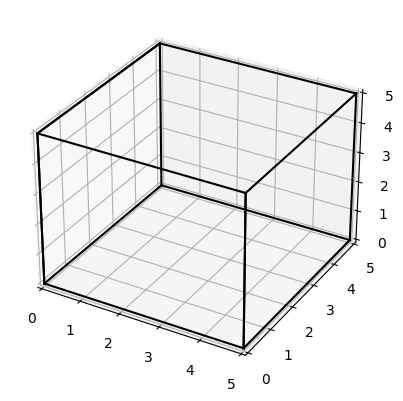

In [4]:
#Gráfico del contenedor objeto de estudio. Uso de librería 3D de matplotlib

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'b', 'g', 'y', 'c', 'm']

# Arcos del contenedor que se evalaurá
edges = [
    [(0, 0, 0), (cont[0], 0, 0)], [(0, 0, 0), (0, cont[1], 0)], [(0, 0, 0), (0, 0, cont[2])],
    [(cont[0], 0, 0), (cont[0], cont[1], 0)], [(cont[0], 0, 0), (cont[0], 0, cont[2])],
    [(0, cont[1], 0), (cont[0], cont[1], 0)], [(0, cont[1], 0), (0, cont[1], cont[2])],
    [(0, 0, cont[2]), (cont[0], 0, cont[2])], [(0, 0, cont[2]), (0, cont[1], cont[2])],
    [(cont[0], cont[1], 0), (cont[0], cont[1], cont[2])], [(cont[0], 0, cont[2]), (cont[0], cont[1], cont[2])], [(0, cont[1], cont[2]), (cont[0], cont[1], cont[2])],
    [(0, 0, cont[2]), (0, cont[1], cont[2])], [(0, 0, 0), (0, 0, cont[2])], [(cont[0], 0, 0), (cont[0], 0, cont[2])]
]
# Dibujo de los arcos del elemento
for edge in edges:
    ax.plot3D(*zip(*edge), color="black")

#Parámetros para la gráfica
ax.set_xlim([0, cont[0]])
ax.set_ylim([0, cont[1]])
ax.set_zlim([0, cont[2]])
# plt.axis('off')
plt.show()

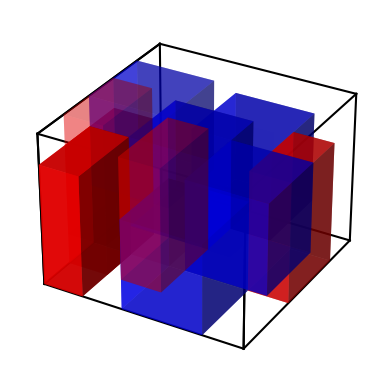

In [5]:
# Visualización del caso de estudio. Esta gráfica muestra una aproximación al problema y muestra una posible solución: ubicarlos de forma aleatoria.
if flag !=1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = ['r', 'b', 'g', 'y', 'c', 'm']

    for edge in edges:
        ax.plot3D(*zip(*edge), color="black")

    # Place bricks randomly for visualization
    #np.random.seed(0)
    for i, (brick_type, dims) in enumerate(blocks.items()):
        for j in range(num_blocks[brick_type]):
            x, y, z = np.random.randint(0, cont[0] - dims[0] + 1), np.random.randint(0, cont[1] - dims[1] + 1), np.random.randint(0, cont[2] - dims[2] + 1)
            dx, dy, dz = dims
            color = colors[i % len(colors)]
            ax.bar3d(x, y, z, dx, dy, dz, color=color, alpha=np.random.random())

    ax.set_xlim([0, cont[0]])
    ax.set_ylim([0, cont[1]])
    ax.set_zlim([0, cont[2]])
    plt.axis('off')
    plt.show()
# Sin embargo, al ver la distribución aleatoria se muestra que hay superposición entre los bloques y que ninguno puede rotarse, lo cual no permitiría encontrar la distribución ideal.
# Con esto en mente, se enfoca la motivación de la solución de este problema para resolver los problemas de superposición y rotación para la implementación que se realice.

## 3. Formulación del Problema

Este problema se modelará como un 3D-SKP (_Three Dimensional Knapsack Problem_), esto por que el problema de ubicar bloques en un contenedor se puede asociar al problema de distribuir una serie de elementos dentro de una mochila. Ahora bien, para el modelo planteado se usarán una discretización de las ubicaciones de los bloques a través de _raster points_ para reducir la complejidad del modelo y así introducir variables binarias en vez de variables continuas. Considerando esta aclaración, el modelo implementado considera: Optimización de la distribución de elementos, rotación de los bloques y la restricción de no-superposición de los elementos. De este modo, el modelo se puede formular de la siguiente forma:

### 1. Parámetros
$C :=$ (Ancho: W, Largo: L, Alto: H) $\to$ Dimensiones del contenedor

$B \to$ Conjunto del tipo de bloques

$n_B \to$ Número de bloques por cada tipo 

$I \to$ Conjunto total de bloques (Items) indexados por $i$

$O \to$ Conjunto de Orientaciones que un prisma puede tomar cada tipo de bloque

$P \to$ Conjunto de Raster Points en la grilla definida para el contenedor

$C \to$ Conjunto de Raster Points que están ocupadas por un bloque

$v_i:=dx_{ik}*dy_{ik}*dz_{ik} \to$ Volumen de cada bloque (i)

### 2. Variable de Decisión

$x_{ijk} \in$ {0,1} $\to$ Variable indicadora si el bloque $i$ esá en el raster point $j$ con la orientación $k$

### 3. Función Objetivo

*max* $\sum_{i\in I} \sum_{j \in P} \sum_{k \in O_i} v_i *x_{ijk}$
### 4. Restricciones

i. Cada Bloque se puede colocar en un único Raster Point:

$\sum_{i \in I} \sum_{k \in O} x_{ijk} \le 1 \qquad \forall j \in P$

ii. Cada Bloque se puede colocar solo 1 vez

$\sum_{j \in P} \sum_{k \in O} x_{ijk} \le 1 \qquad \forall i \in I$


iii. Cada bloque se ubica dentro del Contenedor

$x_j +dx_{ik} \le W, \qquad y_j +dy_{ik} \le L, \qquad x_j +dx_{ik} \le H, \qquad \forall i \in I,{} j \in P,{} k \in O_i$

iv. No traslapo

$\sum_{i\in I} \sum_{j \in P} \sum_{k \in O_i} x_{ijk}\le 1 \qquad \forall i \in I,{} j \in P,{} k \in O_i$


In [6]:
# **PARÁMETROS Y CONSTANTES PARA EL MODELO**


# Diccionario con los bloques
items={}
# Diccionario con las posibles orientaciones de cada bloque
ORIENTATIONS={}
#variable que contabiliza el n+úmero total de elementos que se deben colocar
num_b=0

#Loop para caracterizar todas las direcciones en los cuales cada tipo de bloque puede girarse
for i in blocks.keys():
    ORIENTATIONS[i]= [(blocks[i][0],blocks[i][1],blocks[i][2]), (blocks[i][0],blocks[i][2],blocks[i][1]),(blocks[i][1],blocks[i][0],blocks[i][2]), 
          (blocks[i][1],blocks[i][2],blocks[i][0]), (blocks[i][2],blocks[i][0],blocks[i][1]),(blocks[i][2],blocks[i][1],blocks[i][0])]
        #Llena el diccionario con cada uno de los bloques analizados
    for j in range(num_blocks[i]):
        items[num_b]=(blocks[i],i)
        num_b+=1

#Creación de los raster points para establecer las posiciones en las cuales la esquina inferior izquierda se podrá ubicar
#Discretización de los puntos de ubicación dentro del contenedor
raster_points=[(x,y,z) for x in range(cont[0]) for y in range(cont[1]) for z in range(cont[2])]

#Número de ubicaciones posibles
num_raster=len(raster_points)


In [7]:
# Inicialización del Modelo en Gurobi
model = gp.Model("3D_SKP")


# **VARIABLE DE DECISIÓN**

# # Creación de la Variable de decisión: Variable binaria que indica si un bloque (item) está ubicado en un alguan de las ubicaciones raster (num_raster) y con una dirección (6).
x = model.addVars(items.keys(), range(num_raster), range(6), vtype=GRB.BINARY, name="x")


# **FUNCIÓN OBJETIVO**
# Función Objetivo: Maximizar el volumen de las piezas ubicadas (Calculado como la suamtoria del volumen de las fichas que se colocan -i.e. cuando x_{ijk}=1)
model.setObjective(
    gp.quicksum(np.prod(np.array(items[i][0])) * x[i, rp, k] for i in items for rp in range(num_raster) for k in range(len(ORIENTATIONS[items[i][1]]))),
    GRB.MAXIMIZE
)


# **RESTRICCIONES**

# Restricción: Un bloque se coloca solo una vez
for i in items:
    model.addConstr(gp.quicksum(x[i, rp, k] for rp in range(num_raster) for k in range(len(ORIENTATIONS[items[i][1]]))) <= 1)

# Restricción: Cada rasterpoint tiene solo un bloque
for rp in range(num_raster):
    model.addConstr(gp.quicksum(x[i, rp, k] for i in items for k in range(len(ORIENTATIONS[items[i][1]]))) <= 1)


# Restricción: Mantener los objetos dentro del contenedor
for i in items:
    for rp in range(num_raster):
        for k, (dx, dy, dz) in enumerate(ORIENTATIONS[items[i][1]]):
            x_i_rp_k = x[i, rp, k]
            model.addConstr((raster_points[rp][0]+dx)*x_i_rp_k <= cont[0])
            model.addConstr((raster_points[rp][1]+dy)*x_i_rp_k <= cont[1])
            model.addConstr((raster_points[rp][2]+dz)*x_i_rp_k <= cont[2])

# Diccionario auxiliar para almacenar qué puntos tienen un bloque asignado
occupied = {}  

#Loop para marcar los raster points que estarán usados por un bloque
for i in items:
    for rp in range(num_raster):
            #recorrido de todas las posiciones
        for k, (dx, dy, dz) in enumerate(ORIENTATIONS[items[i][1]]):
            x_i_rp_k = x[i, rp, k]

            # Determinar las celdas ocupadas por este bloque. Recorrido en todas las posibles orientaciones del bloque
            for xi in range(dx):
                for yi in range(dy):
                    for zi in range(dz):
                            #Marca el conjunto de celdas que un bloque ocuparia después de ubicar el raster point de la esquina inferior izquierda
                        point = (raster_points[rp][0] + xi, raster_points[rp][1] + yi, raster_points[rp][2] + zi)
                        
                        if point not in occupied:
                            occupied[point] = []
                        
                        occupied[point].append(x_i_rp_k)

# Restricción: Cada punto de la grilla solo puede ser ocupada por un bloque (Evitar el Sobrelapo)
for point in occupied:
    model.addConstr(gp.quicksum(occupied[point]) <= 1)


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-30


In [8]:
# Ejecución de la optimización con Gurobi
model.optimize()




Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1335U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 27566 rows, 9000 columns and 135000 nonzeros
Model fingerprint: 0x2ba3894c
Variable types: 0 continuous, 9000 integer (9000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [8e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 96.0000000
Presolve removed 27429 rows and 6696 columns
Presolve time: 0.09s
Presolved: 137 rows, 2304 columns, 24192 nonzeros
Found heuristic solution: objective 60.0000000
Variable types: 0 continuous, 2304 integer (2304 binary)

Root relaxation: objective 1.200000e+02, 564 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

In [9]:
#Descripción del resultado
a=0
# Output the solution
if model.status == GRB.OPTIMAL:
    print("Solución óptima encontrada")
    # Imprimir solución
    for i in items:
        for rp in range(num_raster):
            for k in range(len(ORIENTATIONS[items[i][1]])):
                #Si x>0.5, se garantiza que este es uuna ubicación y rotación deseada del elemento
                if x[i, rp, k].x > 0.5:
                    a+=1
                    print(f"Bloque {i} de dimensiones {items[i][0]} fue correctamente ubicado en {raster_points[rp]}")
    print(f'De {num_b} bloques solicitados para ubicar, {a} fueron correctamente asignados')
else:
    print("Solución óptima NO encontrada")

Solución óptima encontrada
Bloque 0 de dimensiones (1, 2, 4) fue correctamente ubicado en (1, 0, 3)
Bloque 1 de dimensiones (1, 2, 4) fue correctamente ubicado en (3, 0, 0)
Bloque 2 de dimensiones (1, 2, 4) fue correctamente ubicado en (0, 0, 0)
Bloque 3 de dimensiones (1, 2, 4) fue correctamente ubicado en (0, 4, 0)
Bloque 4 de dimensiones (1, 2, 4) fue correctamente ubicado en (4, 3, 1)
Bloque 5 de dimensiones (1, 2, 4) fue correctamente ubicado en (0, 1, 4)
Bloque 6 de dimensiones (2, 2, 3) fue correctamente ubicado en (2, 3, 2)
Bloque 7 de dimensiones (2, 2, 3) fue correctamente ubicado en (0, 2, 0)
Bloque 8 de dimensiones (2, 2, 3) fue correctamente ubicado en (1, 0, 0)
Bloque 9 de dimensiones (2, 2, 3) fue correctamente ubicado en (0, 2, 2)
Bloque 10 de dimensiones (2, 2, 3) fue correctamente ubicado en (2, 1, 3)
Bloque 11 de dimensiones (2, 2, 3) fue correctamente ubicado en (3, 0, 1)
De 12 bloques solicitados para ubicar, 12 fueron correctamente asignados


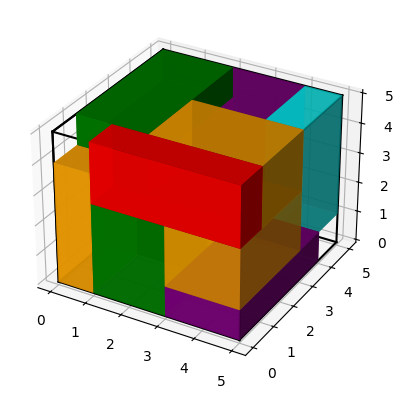

In [13]:
# Visualización
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]

#Dibujo de los arcos del contenedor
for edge in edges:
    ax.plot3D(*zip(*edge), color="black")

#Dibujo de los bloques en la solución
a=0
if model.status == GRB.OPTIMAL:
    for i in items:
        for rp in range(num_raster):
            for k in range(len(ORIENTATIONS[items[i][1]])):
                
                if x[i, rp, k].x > 0.5:
                    dx, dy, dz = ORIENTATIONS[items[i][1]][k]
                    x_val,y_val,z_val=raster_points[rp]
                    color = colors[random.sample([i for i in range(len(colors))],1)[0]]
                    ax.bar3d(x_val, y_val, z_val, dx, dy, dz, color=color, alpha=np.random.uniform(low=0.5, high=0.99))
                    a+=1

# ax.set_xlim([0, cont[0]])
# ax.set_ylim([0, cont[1]])
# ax.set_zlim([0, cont[2]])
# plt.axis('off')
plt.show()
